In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import spilu
import scipy.sparse as sps

import math

import jlinops

In [2]:
grid_shape = (13, 4)
R = jlinops.Dirichlet2DSym(grid_shape)
A = R.T @ R
Amat = jlinops.black_box_to_dense(A)

In [3]:


def build_neumann2d_sparse_matrix(grid_shape):
     """Makes a sparse matrix corresponding to the matrix-free Neumann2D operator.
     """

     m, n = grid_shape

     Rv, _ = jlinops.first_order_derivative_1d(m, boundary="reflexive")
     Rv *= -1.0

     Rh, _ = jlinops.first_order_derivative_1d(n, boundary="reflexive")
     Rh *= -1.0

     

     return sps.vstack([sps.kron(Rv, sps.eye(n)), sps.kron(sps.eye(m), Rh) ])



In [4]:
A = build_neumann2d_sparse_matrix(grid_shape).toarray()
A = A.T @ A

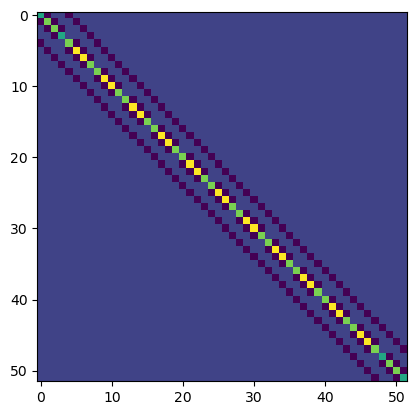

In [5]:
plt.imshow(A)

In [6]:
m, n = grid_shape
d = 4*np.ones(math.prod(grid_shape))

# Inner 3's
d[ n : -n : n ] -= 1
d[ 2*n - 1 : -n : n ] -= 1

# First and last 2's, and 3's
d[0] = 2
d[-1] = 2
d[n-1] = 2
d[-n] = 2
d[1:n-1] = 3
d[-n+1:-1] = 3

In [7]:
d

array([2., 3., 3., 2., 3., 4., 4., 3., 3., 4., 4., 3., 3., 4., 4., 3., 3.,
       4., 4., 3., 3., 4., 4., 3., 3., 4., 4., 3., 3., 4., 4., 3., 3., 4.,
       4., 3., 3., 4., 4., 3., 3., 4., 4., 3., 3., 4., 4., 3., 2., 3., 3.,
       2.])

In [8]:
grid_shape

(13, 4)

In [9]:
np.linalg.norm(d - A.diagonal(offset=0))

0.0

In [10]:
type(A)

numpy.ndarray

In [11]:
grid_shape

(13, 4)

In [12]:
A.diagonal(offset=-1).shape

(51,)

In [13]:
A.diagonal(offset=-1)

array([-1., -1., -1.,  0., -1., -1., -1.,  0., -1., -1., -1.,  0., -1.,
       -1., -1.,  0., -1., -1., -1.,  0., -1., -1., -1.,  0., -1., -1.,
       -1.,  0., -1., -1., -1.,  0., -1., -1., -1.,  0., -1., -1., -1.,
        0., -1., -1., -1.,  0., -1., -1., -1.,  0., -1., -1., -1.])

In [14]:
l = -1*np.ones(math.prod(grid_shape) - 1)
l[n-1::n] = 0

In [15]:
np.linalg.norm( l - A.diagonal(offset=-1))

0.0

# Function for pseudoinverse

In [16]:
from scipy.sparse.linalg import cg as sp_cg
from jlinops import _CustomLinearOperator, get_device, Neumann2D, DiagonalOperator

In [17]:
from jlinops import get_neumann2d_laplacian_diagonal, get_neumann2d_laplacian_tridiagonal, TridiagInvOperator

In [18]:

class CGWeightedNeumann2DSimplePinvOperator(_CustomLinearOperator):
    """Represents the pseudoinverse (R_w)^\dagger of a linear operator R_w = D_w R, where
    D_w is a diagonal matrix of weights and R is a Neumann2D operator.
    Here matvecs/rmatvecs are applied approximately using a preconditioned conjugate
    gradient method, where the preconditioner is based on the operator with identity weights. 
    """

    def __init__(self, grid_shape, weights, which="diagonal", *args, **kwargs):

        assert 2*math.prod(grid_shape) == len(weights), "Weights incompatible!"
        assert which in ["diagonal", "tridiagonal"], f"which must be one of diagonal, tridiagonal."
        self.weights = weights
        self.grid_shape = grid_shape
        self.n = math.prod(grid_shape)
        # self.warmstart_prev = warmstart_prev
        # self.check = check
        self.which = which
        self.args = args
        self.kwargs = kwargs
        
        # Figure out device
        self.device = get_device(weights)

        # Build R and R_w
        self.R = Neumann2D(grid_shape, device=self.device)
        self.m = self.R.shape[0]
        self.RtR = self.R.T @ self.R
        self.Dw = DiagonalOperator(weights)
        self.Rw = self.Dw @ self.R
        self.C = self.Rw.T @ self.Rw
        

        # Set up preconditioning operator
        if self.which == "diagonal":

            # Get diagonal
            d = get_neumann2d_laplacian_diagonal(self.grid_shape)
            M = DiagonalOperator(1.0/d)

        elif self.which == "tridiagonal":
            
            l, d, u = get_neumann2d_laplacian_tridiagonal(self.grid_shape)
            M = TridiagInvOperator(l, d, u)

        else:

            raise NotImplementedError

        def _matvec(x):

            tmp = self.Rw.rmatvec(x)
            sol, converged = sp_cg( self.C, tmp, x0=None, M=M, *args, **kwargs) 
            
            return sol
        
        def _rmatvec(x):

            sol, converged = sp_cg( self.C, x, x0=None, M=M, *args, **kwargs) 
            tmp = self.Rw.matvec(sol)

            return tmp

        
        super().__init__( (self.n, self.m), _matvec, _matvec, dtype=np.float64, device="cpu")

    def to_gpu(self):
        return CGWeightedNeumann2DSimplePinvOperator( self.grid_shape, cp.asarray(self.weights), which=self.which, *self.args, **self.kwargs)
    
    def to_cpu(self):
        return CGWeightedNeumann2DSimplePinvOperator( self.grid_shape, cp.asnumpy(self.weights), which=self.which, *self.args, **self.kwargs)
    

In [26]:
grid_shape = (6, 10)
_R = jlinops.Neumann2D(grid_shape)
weights = np.random.uniform(low=1, high=10, size=_R.shape[0])
A1 = CGWeightedNeumann2DSimplePinvOperator(grid_shape, weights, which="diagonal")
A2 = CGWeightedNeumann2DSimplePinvOperator(grid_shape, weights, which="tridiagonal")

In [28]:
A1.shape

(60, 120)

In [29]:
z = np.random.normal(size=120)

In [30]:
A1 @ z

array([-0.03428843, -0.01396831, -0.16516632, -0.42161132, -0.06622109,
       -0.10274543, -0.06372215,  0.41459025,  0.44989874,  0.16103319,
       -0.08570459, -0.13767873, -0.36112004, -0.34897882, -0.01973881,
        0.2071232 ,  0.42003003,  0.37823228,  0.26757992,  0.05673395,
        0.01614987, -0.03448938,  0.0149646 , -0.09954554, -0.11129278,
        0.10461939,  0.1568005 ,  0.25165027,  0.0254564 , -0.11114506,
       -0.17856891, -0.04746322, -0.07494091, -0.16827746,  0.05517746,
        0.08445815, -0.10541397, -0.14555103,  0.17760886,  0.04998357,
       -0.14654132,  0.03552151, -0.15588871, -0.20056217, -0.08626065,
       -0.12817719, -0.17940903, -0.13846776,  0.22303181,  0.14132623,
        0.44308697,  0.16607455,  0.0412746 ,  0.13253282,  0.04184024,
       -0.14589722, -0.16794039, -0.07924727,  0.02644949,  0.02960951])

In [31]:
A2 @ z

array([-0.03276693, -0.01244808, -0.16364642, -0.42009739, -0.06469776,
       -0.10122262, -0.06220136,  0.41611148,  0.45142074,  0.16255496,
       -0.08418396, -0.13615955, -0.35960013, -0.34745878, -0.01821758,
        0.20864454,  0.42154801,  0.37975401,  0.26909867,  0.05825598,
        0.01766964, -0.03296815,  0.01648683, -0.09802546, -0.10977258,
        0.10613999,  0.15832099,  0.25317054,  0.02697373, -0.10962967,
       -0.17704879, -0.04594356, -0.07342107, -0.16675769,  0.05669792,
        0.0859783 , -0.10389482, -0.14403231,  0.17912145,  0.05149743,
       -0.14502041,  0.03704099, -0.15437157, -0.19904619, -0.08474082,
       -0.12665509, -0.17788833, -0.13694704,  0.22454833,  0.14284324,
        0.44460578,  0.16759342,  0.04279161,  0.13404896,  0.04335864,
       -0.1443716 , -0.1664154 , -0.07772731,  0.02796748,  0.03112778])

In [34]:
from scipy.linalg import sp_solve_banded

ImportError: cannot import name 'sp_solve_banded' from 'scipy.linalg' (/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/scipy/linalg/__init__.py)

In [41]:

class TridiagInvOperator(_CustomLinearOperator):
    """Represents the inverse of a tridiagonal matrix.
    l: lower off diagonal
    d: diagonal
    u: upper off diagonal
    """

    def __init__(self, l, d, u):

        self.n = len(d)
        assert len(l) == self.n - 1, "lower diagonal inconsistent."
        assert len(u) == self.n - 1, "upper diagonal inconsistent."

        # Store diagonals
        self.l = l
        self.d = d
        self.u = u 

        # Figure out device
        self.device = get_device(d)

        if self.device == "cpu":

            # Helper matrix
            self.Z = np.zeros((3, self.n))
            self.Z[0, 1:] = self.u  # Superdiagonal
            self.Z[1, :] = self.d  # Main diagonal
            self.Z[2, :-1] = self.l  # Subdiagonal
            self.Zt = self.Z.T

            def _matvec(x):

                sol = sp_solve_banded((1, 1), self.Z, x)
                
                return sol
            
            def _rmatvec(x):

                sol = sp_solve_banded((1, 1), self.Zt, x)
                
                return sol
            
        else:

            # Helper matrix
            self.Z = cp.zeros((3, self.n))
            self.Z[0, 1:] = self.u  # Superdiagonal
            self.Z[1, :] = self.d  # Main diagonal
            self.Z[2, :-1] = self.l  # Subdiagonal
            self.Zt = self.Z.T

            def _matvec(x):

                sol = cp_solve_banded((1, 1), self.Z, x)
                
                return sol
        
            def _rmatvec(x):

                sol = cp_solve_banded((1, 1), self.Zt, x)
                
                return sol
            
        
        super().__init__( (self.n, self.n), _matvec, _rmatvec, dtype=np.float64, device=self.device)

    def to_gpu(self):
        l = cp.asarray(self.l)
        d = cp.asarray(self.d)
        u = cp.asarray(self.u)
        return TridiagInvOperator(l, d, u)
    
    def to_cpu(self):
        l = cp.asnumpy(self.l)
        d = cp.asnumpy(self.d)
        u = cp.asnumpy(self.u)
        return TridiagInvOperator(l, d, u)
    

In [35]:
L = jlinops.random_lower_triangular(10, 3)
A = L @ L.T
Amat = A.toarray()
l, d, u = jlinops.extract_tridiag(A)

In [36]:
T = TridiagInvOperator(l, d, u)

In [37]:
Tinv_mat = jlinops.black_box_to_dense(T)

In [38]:
K = jlinops.build_tridiag(l, d, u).toarray()
Kinv = np.linalg.inv(K)

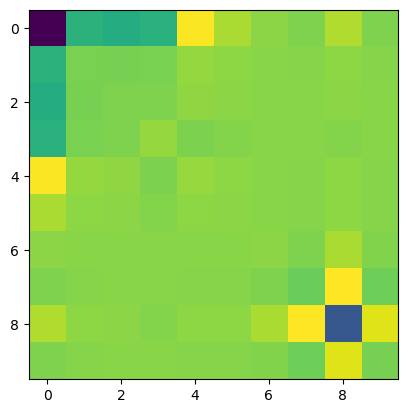

In [39]:
plt.imshow(Kinv)
plt.show()

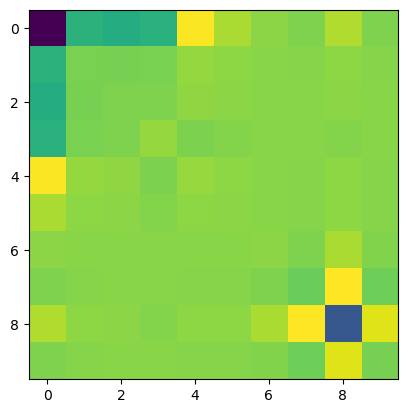

In [40]:
plt.imshow(Tinv_mat)
plt.show()